In [107]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython import display

In [25]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') # so we can do .to(device)
else:
    device = torch.device('cpu')

# REINFORCE

REINFORCE is an on-policy (i.e., the model is trained exclusively on data generated using the current policy) policy gradient algorithm. Let our policy $\pi$ to be parametrized by $\theta$ (e.g., parameters of a neural network). Our goal is to find the parameter $\theta$ that maximizes the expected return of trajectory $G(\tau)$, where $\tau$ denotes a trajectory obtained from following policy $\pi_{\theta}$. So the objective can be written as:

$$
J (\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}} [G(\tau)]
$$

The policy gradient is then (we will skip the derivation of the policy gradient for now, but I highly encourage you to look at it):

$$
\nabla_{\theta} J (\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}} [\sum_{t=0}^{T} G_{t}(\tau) \nabla_{\theta} \log \pi_{\theta}(a_t|s_t)]
$$

Once we know $\nabla_{\theta} J (\theta)$, we can update $\theta$ with gradient ascent. In practice, we approximate the policy gradient via Monte-Carlo sampling by just considering a **single** trajectory, which gives us:

$$
\nabla_{\theta} J (\theta) \approx \sum_{t=0}^{T} G_{t}(\tau) \nabla_{\theta} \log \pi_{\theta}(a_t|s_t)
$$

The REINFORCE algorithm is shown below:

<figure>
  <div style="text-align:center;">
  <img src="assets/05/reinforce_algo.png", width = 750>
  <figcaption>Source: Richard S. Sutton and Andrew G. Barto. Reinforcement Learning: An Introduction.</figcaption>
  </div>
</figure>

For each iteration, we collect an episode trajectory following the current policy. At the end of each episode, we use this trajectory to get the return $G$ and log probability of action at each time step within the episode, which allows us to compute the policy gradient and update the parameters of the policy. After we update our network, we forget about the trajectory we just collected and collect a new one with the latest policy, and the processes are repeated.

Let's take a look at the implementation. The code below is adapted from REINFORCE implementation example from PyTorch repo (source: https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py).

In [78]:
# Initialize the environment
env = gym.make('CartPole-v1',render_mode="rgb_array")

In [79]:
# Create the policy network
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, action_dim)
        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, inp):
        x = self.fc1(inp)
        x = self.dropout(x)
        x = F.relu(x)
        logits = self.fc2(x)
        out = F.softmax(logits, dim = 1)
        return out

In [102]:
class REINFORCEAgent(object):
    def __init__(self, state_dim, action_dim):
        super(REINFORCEAgent, self).__init__()
        self.policy = PolicyNet(state_dim, action_dim).to(device)
        self.policy.train()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-2)
        self.gamma = 0.99
        self.log_interval = 10 # print progress per this many episodes
    
    def clean_memory(self):
        del self.policy.rewards[:]
        del self.policy.saved_log_probs[:]
    
    def select_action(self, input_state):
        state = torch.from_numpy(input_state).float().unsqueeze(0)
        action_probs = self.policy(state)
        m = Categorical(action_probs)
        action = m.sample()
        self.policy.saved_log_probs.append(m.log_prob(action))
        return action.item()

    def update(self):
        G = 0
        policy_loss = []
        returns = []
        for r in self.policy.rewards[::-1]:
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-7) # normalized returns
        for log_prob, G in zip(self.policy.saved_log_probs, returns):
            policy_loss.append(-log_prob * G)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum() # a scalar
        policy_loss.backward()
        self.optimizer.step()
        self.clean_memory() # empty self.rewards and self.saved_log_probs (on-policy!)

Let's start training the agent.

In [103]:
state_dim = 4 # (x, x_dot, theta, theta_dot)
action_dim = 2 # (0, 1)
agent = REINFORCEAgent(state_dim, action_dim)

In [109]:
running_reward = 10
ep_rewards = [] # to store episode reward so we can plot it later
for i in range(1, 10000):
    state, ep_reward = env.reset(), 0
    state = state[0]
    for _ in range(1, 10000):
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        agent.policy.rewards.append(reward)
        ep_reward += reward
        env.render()
        if terminated or truncated:
            break
    ep_rewards.append(ep_reward)
    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    agent.update()
    
    if i % agent.log_interval == 0:
        print('Episode %d \t Running Reward: %.2f \t Last Episode Reward: %d' % (i, running_reward, ep_reward))
    
    # Stopping criteria
    if running_reward > 200:
        print('Solved: Episode %d \t Running Reward: %.2f \t Last Episode Reward: %d' 
              % (i, running_reward, ep_reward))
        break

Episode 10 	 Running Reward: 61.30 	 Last Episode Reward: 15
Episode 20 	 Running Reward: 181.71 	 Last Episode Reward: 276
Solved: Episode 22 	 Running Reward: 208.09 	 Last Episode Reward: 407


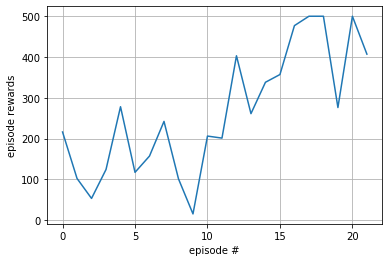

In [110]:
plt.plot(ep_rewards)
plt.xlabel('episode #')
plt.ylabel('episode rewards')
plt.grid()
plt.show()

198.0


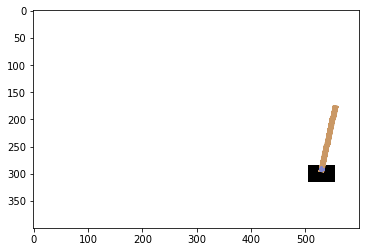

In [111]:
state = env.reset()
state = state[0]
terminated = False
truncated = False
total_reward = 0
while not (terminated or truncated):
    action = agent.select_action(state)
    state, reward, terminated, truncated,  _ = env.step(int(action))
    total_reward += reward
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminated or truncated:
        break
print(total_reward)

In [ ]:
env.close()